**Note** Error terms $e$ are yielding incorrect estimators!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Assume that we have a variable $Y$ such that $f_Y(D, e_Y) = \alpha + \delta D + e$.  
Now introduce a possible instrumental variable $Z$.

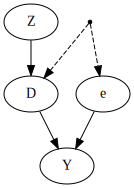

In [2]:
from causalgraphicalmodels import CausalGraphicalModel

iv = CausalGraphicalModel(
    nodes=["Z", "D", "Y", "e"],
    edges=[
        ("Z", "D"), 
        ("D", "Y"),
        ('e', 'Y')
    ],
    latent_edges=[
        ('e', 'D')
    ]
)

iv.draw()

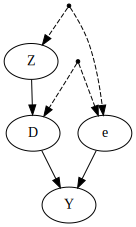

In [3]:
from causalgraphicalmodels import CausalGraphicalModel

iv_p = CausalGraphicalModel(
    nodes=["Z", "D", "Y", "e"],
    edges=[
        ("Z", "D"), 
        ("D", "Y"),
        ('e', 'Y')
    ],
    latent_edges=[
        ('e', 'D'),
        ('e', 'Z')
    ]
)

iv_p.draw()

In graphs $iv$ and $iv_p$ we are prevented from taking a least squares regression of $Y$ on $D$ by the backdoor path $D \leftrightarrow e \rightarrow Y$. Doing so would yield an inconsistent or unbiased estimate of the effect of $D$ on $Y$.  
Since $e$ is an unobserved error term, there are no variables satisfying the Back Door Criterion.

Potential instrumental variable $Z$ has a relationship with $Y$, through the path $Z \rightarrow D \rightarrow Y$.  
$Z$ does not generate statistical dependence with $Y$ through the path $Z \rightarrow D \leftrightarrow e \rightarrow Y$, because of collider $D$.  
In $iv_p$, the path $Z \leftrightarrow e \rightarrow Y$ does create statistical dependence. So $Z$ cannot be used in the scenario represented by that graph.

With the assumption that the effect of $D$ on $Y$ is constant $\delta$ we can obtain a consistent estimator by isolating the covariation between $D$ and $Y$ that is causal. Then we could ignore the noncausal covariation, as the result of common causes of $D$ and $e$.  
In $iv$, $Z$ serves as an isolated source of variation for $D$, but not in $iv_p$.

The Wald estimator, $\delta_{WALD}$ \~ $\frac{\mathbb{E}[Y|Z = 1] - \mathbb{E}[Y|Z = 0]}{\mathbb{E}[D|Z = 1] - \mathbb{E}[D|Z = 0]}$, provides a consistent estimate of the causal effect of $D$ on $Y$ (if $D$ is binary).

In the case of $iv_p$, the nonzero association between $Z$ and $e$ we do not find a consistent $\delta$ from the WALD estimator. It converges to $\delta$ plus a bias term of the net association between $Z$ and $e$.

### IV Demonstration 1

School voucher program to be examined in a metropolitan area.  
Randomly select 10 000 ninth graders and give them a standardized test. Collect scores as $\{y_i, d_i\}^{10 000}_{i = 1}$, for scores $Y$ and $D = 1$ if a student attended a private high school and $0$ otherwise.

10% of students win a voucher redeemable at a private high school. $z_i = 1$ for winners and $0$ otherwise.

In [4]:
units = 10000

p_z = .1 #probability of winning a voucher
Z = np.random.binomial(1, p_z, size=units)

e = np.random.normal(0, 5, size=units)

#Probability of attending private school is greater for lottery winners
p_d = .1 + Z / 10. + e / (abs(e).max() * 10)
D = np.random.binomial(1, p_d)

#Scores Y are of the form y = \alpha + \beta * D + e
Y = 50 + 10 * D + e

df = pd.DataFrame({'Z': Z, 'e': e, 'D': D, 'Y': Y})

In [5]:
df.head()

,Z,e,D,Y
0,0,-1.390371,0,48.609629
1,0,11.753197,0,61.753197
2,0,-1.064410,0,48.935590
3,0,3.663382,0,53.663382
4,0,-7.657432,0,42.342568


**Note** This is on the low end of interdependence between an instrumental variable and causal state of interest.

In [6]:
df[['Z', 'D']].corr()

,Z,D
Z,1.000000,0.092192
D,0.092192,1.000000


This data generating process corresponds to $iv$, since $D$ lies on the path between $Z$ and $e$ there is no statistical dependence between them.  
We can estimate the causal effect of $D$ on $Y$ with the WALD estimator.

In [7]:
(df[df['Z'] == 1].Y.mean() - df[df['Z'] == 0].Y.mean()) / (df[df['Z'] == 1].D.mean() - df[df['Z'] == 0].D.mean())

8.848261887355587

That's quite close to the true effect, which from our data generating process was $\beta = 10$.

Now let's try to fit an OLS to recover $f_Y$.

In [8]:
from statsmodels.api import OLS, Logit

In [9]:
df['intercept'] = 1
instrument_model = Logit(df['D'], df[['Z', 'intercept']])
instrument_result = instrument_model.fit()

df['D_expected'] = instrument_result.predict(df[['Z', 'intercept']])
causal_model = OLS(df['Y'], df[['D_expected', 'intercept']])
result = causal_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.349313
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     17.67
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           2.65e-05
Time:                        07:40:22   Log-Likelihood:                -32347.
No. Observations:               10000   AIC:                         6.470e+04
Df Residuals:                    9998   BIC:                         6.471e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
D_expected     8.8483      2.105      4.204      0.000       4.722      12.974
intercept     50.1870      0.246    204.116      0.000      49.705      50.669
==============================================================================
Omnibus:                      392.282   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              451.859
Skew:                           0.473   Prob(JB):                     7.59e-99
Kurtosis:                       3.437   Cond. No.                         34.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We've just about got it. The coefficients for D_expected and intercept are close to the true values of 10 and 50, respectively.

Using statsmodels built-in 2SLS

In [10]:
from statsmodels.sandbox.regression.gmm import IV2SLS

In [11]:
model = IV2SLS(df['Y'], df[['D', 'intercept']], instrument=df[['Z', 'intercept']])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          IV2SLS Regression Results                           
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.322
Model:                         IV2SLS   Adj. R-squared:                  0.322
Method:                     Two Stage   F-statistic:                     26.02
                        Least Squares   Prob (F-statistic):           3.45e-07
Date:                Mon, 17 Dec 2018                                         
Time:                        07:40:22                                         
No. Observations:               10000                                         
Df Residuals:                    9998                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
D              8.8483      1.735      5.100      0.000       5.448      12.249
intercept     50.1870      0.203    247.669      0.000      49.790      50.584
==============================================================================
Omnibus:                        4.175   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.124   Jarque-Bera (JB):                4.224
Skew:                           0.034   Prob(JB):                        0.121
Kurtosis:                       3.075   Cond. No.                         3.20
==============================================================================
"""

Now lets introduce statistical dependence between $Z$ and $e$ through a confounder $A$.

In [12]:
units = 10000

A = np.random.normal(size=units) #Confounder

p_z = .1 + A / (10 * abs(A).max()) #probability of winning a voucher
Z = np.random.binomial(1, p_z, size=units)

e = np.random.normal(5 * A, 5, size=units)

#Probability of attending private school is greater for lottery winners
p_d = .1 + Z / 10. + e / (abs(e).max() * 10)
D = np.random.binomial(1, p_d)

#Scores Y are of the form y = \alpha + \beta * D + e
Y = 50 + 10 * D + e

df = pd.DataFrame({'A': A, 'Z': Z, 'e': e, 'D': D, 'Y': Y})

In [13]:
df.corr()

,A,Z,e,D,Y
A,1.000000,0.077438,0.705761,0.067702,0.648881
Z,0.077438,1.000000,0.061821,0.111696,0.098721
e,0.705761,0.061821,1.000000,0.094959,0.919023
D,0.067702,0.111696,0.094959,1.000000,0.479693
Y,0.648881,0.098721,0.919023,0.479693,1.000000


Now we have a correlation between $Z$ and $e$.

In [14]:
df['intercept'] = 1
instrument_model = Logit(df['D'], df[['Z', 'intercept']])
instrument_result = instrument_model.fit()

df['D_expected'] = instrument_result.predict(df[['Z', 'intercept']])
causal_model = OLS(df['Y'], df[['D_expected', 'intercept']])
result = causal_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.346475
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     98.40
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           4.37e-23
Time:                        07:40:22   Log-Likelihood:                -34909.
No. Observations:               10000   AIC:                         6.982e+04
Df Residuals:                    9998   BIC:                         6.984e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
D_expected    22.3195      2.250      9.920      0.000      17.909      26.730
intercept     48.7806      0.265    183.873      0.000      48.261      49.301
==============================================================================
Omnibus:                      129.987   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.233
Skew:                           0.275   Prob(JB):                     4.31e-30
Kurtosis:                       3.145   Cond. No.                         28.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The estimated coefficient of $D$ is very biased now, since we are picking some of the causal dependence through the backdoor path created by $A$.  
We can alleviate this by conditioning on $A$ in our OLS.

In [15]:
df['D_expected'] = instrument_result.predict(df[['Z', 'intercept']])
causal_model = OLS(df['Y'], df[['D_expected', 'A', 'intercept']]) #Include A in the regression
result = causal_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     3671.
Date:                Mon, 17 Dec 2018   Prob (F-statistic):               0.00
Time:                        07:40:22   Log-Likelihood:                -32205.
No. Observations:               10000   AIC:                         6.442e+04
Df Residuals:                    9997   BIC:                         6.444e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
D_expected    11.0252      1.722      6.402      0.000       7.649      14.401
A              5.1672      0.061     84.689      0.000       5.048       5.287
intercept     49.9517      0.203    246.166      0.000      49.554      50.349
==============================================================================
Omnibus:                      378.550   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              437.617
Skew:                           0.459   Prob(JB):                     9.39e-96
Kurtosis:                       3.457   Cond. No.                         29.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

That's a lot better! Understanding the causal graph allowed us to recover the data generating process, even with the existence of a confounder.

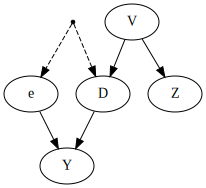

In [16]:
iv_surrogate = CausalGraphicalModel(
    nodes=["Z", "V", "D", "Y", "e"],
    edges=[
        ("V", "Z"),
        ("V", "D"), 
        ("D", "Y"),
        ('e', 'Y')
    ],
    latent_edges=[
        ('e', 'D')
    ]
)

iv_surrogate.draw()

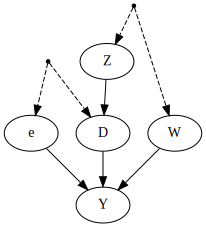

In [17]:
iv_conditional = CausalGraphicalModel(
    nodes=["Z", "W", "D", "Y", "e"],
    edges=[
        ("Z", "D"), 
        ("D", "Y"),
        ('e', 'Y'),
        ("W", "Y")
    ],
    latent_edges=[
        ('e', 'D'),
        ('W', 'Z')
    ]
)

iv_conditional.draw()

In both $iv_{surrogate}$ and $iv_{conditional}$, $Z$ is a valid instrumental variable. In the former, $V$ is unobserved, but $Z$ is a surrogate which has an association with $D$ even if it is not a direct cause of $D$. A possible complication in this case is a weak association between $Z$ and $D$. In the latter, $Z$ has an association with $Y$ through a path other than that through $D$, $Z \leftrightarrow W \rightarrow Y$. But this backdoor path can be blocked by conditioning on $W$ (see below) during estimation.

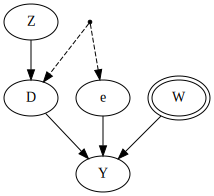

In [18]:
iv_c_do = iv_conditional.do('W')
iv_c_do.draw()

### Examples

Causal effect of interest: years of schooling on subsequent earnings  
IVs: proximity to college, regional and temporal variation in school construction, tuition at local colleges, temporal variation in minimum school-leaving age, quarter of birth.  

Surrogate instrumental variable

In [19]:
units = 10000
alpha = 50
delta = 10

V = np.random.binomial(1, .5, size=units) #Parental graduation (not realistic because of causal effects on childrens' earnings) 

Z = np.random.exponential(1.5 - V, size=units) #Distance from some college
#College-educated parents are expected to live closer to colleges

p_d = .15 - V / 10  
D = np.random.binomial(1, p_d) #Years of schooling. greater than k for some int k
#Children of college-educated parents are expected to attend school for longer

e = np.random.normal(5, size=units) #Individual effects

Y = alpha + delta * D + e #Earnings

df = pd.DataFrame({'V': V, 'Z': Z, 'D': D, 'e': e, 'Y': Y})

In [20]:
df[['Z', 'D']].corr()

,Z,D
Z,1.000000,0.057547
D,0.057547,1.000000


Even though there is no causal relationship between $Z$ and $D$, since both are caused by $V$ we get a statistical association.

First we require that $Cov(e, Z) = 0$. If that holds then we should be able to recover $\delta$.

In [21]:
df[['e', 'Z']].corr()

,e,Z
e,1.000000,0.002068
Z,0.002068,1.000000


The OLS estimate works

In [22]:
df[['Y', 'D']].corr().Y.D / df['D'].var()

10.67400253720443

In [23]:
df[['Y', 'Z']].corr().Y.Z / df[['D', 'Z']].corr().D.Z

0.9571332364053134

**Note** Not sure what the missing piece is here?

Conditional instrumental variable

Draft lottery

In [24]:
units = 10000
alpha = 50
delta = 10

Z = np.random.randint(1, 12, size=units) #Month of birth

e = np.random.uniform(0, .25, size=units) #Individual effects

p_d = [.25 if i <= 6 else .5 for i in Z] #Chances of being drafted are greater for latter months
D = np.random.binomial(1, p_d + e) #1 for drafted, 0 otherwise

W = np.random.normal(6. - Z / 2.) #Success in school, assumed to be affected by date of birth

Y = alpha + delta * D + e #Earnings

df = pd.DataFrame({'Z': Z, 'e': e, 'D': D, 'W': W, 'Y': Y})

In [25]:
df[['Z', 'D']].corr()

,Z,D
Z,1.000000,0.220753
D,0.220753,1.000000


In [26]:
df[['e', 'Z']].corr()

,e,Z
e,1.000000,0.004833
Z,0.004833,1.000000


We have the necessary correlation between the IV $Z$ and the causal state of interest $D$.  
We have no correlation between $e$ and $Z$, as required.  
By conditioning on $W$ we should be able to block that backdoor path and recover the data generating process.

In [27]:
df['intercept'] = 1
instrument_model = Logit(df['D'], df[['Z', 'intercept']])
instrument_result = instrument_model.fit()

df['D_expected'] = instrument_result.predict(df[['Z', 'intercept']])
causal_model = OLS(df['Y'], df[['D_expected', 'W', 'intercept']])
result = causal_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.667881
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     260.2
Date:                Mon, 17 Dec 2018   Prob (F-statistic):          6.60e-111
Time:                        07:40:22   Log-Likelihood:                -30046.
No. Observations:               10000   AIC:                         6.010e+04
Df Residuals:                    9997   BIC:                         6.012e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
D_expected     8.7298      0.817     10.680      0.000       7.127      10.332
W             -0.0934      0.048     -1.938      0.053      -0.188       0.001
intercept     51.0185      0.525     97.163      0.000      49.989      52.048
==============================================================================
Omnibus:                        6.641   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.036   Jarque-Bera (JB):             1340.552
Skew:                           0.063   Prob(JB):                    7.99e-292
Kurtosis:                       1.211   Cond. No.                         72.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Just about!  
But not including $W$ works well, too?

In [28]:
df['D_expected'] = instrument_result.predict(df[['Z', 'intercept']])
causal_model = OLS(df['Y'], df[['D_expected', 'intercept']])
result = causal_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     516.6
Date:                Mon, 17 Dec 2018   Prob (F-statistic):          1.51e-111
Time:                        07:40:22   Log-Likelihood:                -30048.
No. Observations:               10000   AIC:                         6.010e+04
Df Residuals:                    9998   BIC:                         6.011e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
D_expected    10.0613      0.443     22.729      0.000       9.194      10.929
intercept     50.0943      0.220    228.098      0.000      49.664      50.525
==============================================================================
Omnibus:                        6.698   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.035   Jarque-Bera (JB):             1342.174
Skew:                           0.063   Prob(JB):                    3.55e-292
Kurtosis:                       1.210   Cond. No.                         11.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

That might even be better!  
**Note** Try altering the data generating process to see is the correlation strengths are a factor.

#### Surrogate IV  
Effect of Catholic school attendance on test scores  
IV: Catholic share of local population

In [29]:
units = 10000
alpha = 25
delta = 10

V = np.random.binomial(1, .25, size=units) #Family is Catholic, unobserved

Z = np.random.uniform(0, 50 * (1 + V)) #Catholic share of population, increases for Catholic families

e = np.random.uniform(0, 10, size=units) #Individual effects

p_d = 1. / (10. + e) + .5 * V #Probability of attending Catholic school increases with V
D = np.random.binomial(1, p_d) #Attends Catholic school

Y = alpha + delta * D + e #Test scores

df = pd.DataFrame({'Z': Z, 'e': e, 'D': D, 'Y': Y})

Living in a Catholic neighborhood $Z$ serves as a surrogate IV for attending a Catholic school $D$, since both are caused by being in a Catholic family $V$.

In [30]:
df[['Z', 'D']].corr()

,Z,D
Z,1.000000,0.269812
D,0.269812,1.000000


$Z$ and the error term $e$ are independent.

In [31]:
df[['Z', 'e']].corr()

,Z,e
Z,1.000000,0.000217
e,0.000217,1.000000


We should be able to recover $\delta$ from the covariances.

In [32]:
df[['Y', 'Z']].corr().Y.Z / df[['D', 'Z']].corr().D.Z

0.8219689598939669

In [33]:
df.corr()

,Z,e,D,Y
Z,1.000000,0.000217,0.269812,0.221777
e,0.000217,1.000000,-0.034475,0.570930
D,0.269812,-0.034475,1.000000,0.800828
Y,0.221777,0.570930,0.800828,1.000000


Maybe I am misinterpreting a "constant structural effect"?

In [34]:
df['intercept'] = 1
instrument_model = Logit(df['D'], df[['Z', 'intercept']])
instrument_result = instrument_model.fit()
instrument_result.summary()

df['D_expected'] = instrument_result.predict(df[['Z', 'intercept']])
causal_model = OLS(df['Y'], df[['D_expected', 'intercept']])
result = causal_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.458976
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                 6.262e+05
Date:                Mon, 17 Dec 2018   Prob (F-statistic):               0.00
Time:                        07:40:50   Log-Likelihood:            -2.9611e+07
No. Observations:            10000000   AIC:                         5.922e+07
Df Residuals:                 9999998   BIC:                         5.922e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
D_expected    10.7379      0.014    791.331      0.000      10.711      10.765
intercept     29.8567      0.003   9868.320      0.000      29.851      29.863
==============================================================================
Omnibus:                   670652.133   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           815236.530
Skew:                           0.697   Prob(JB):                         0.00
Kurtosis:                       3.117   Cond. No.                         9.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There is error in the estimated intercept, off by 5.  
Not sure why

#### Communities

Messner, Baumer and Rosenfeld (2004)  
Units: communities  
Causal states: $D_1$ Social trust (1) and $D_2$ social activism (2)  
Response: $Y$ Homicide rate  
IVs: $Z_1$ Alienation metric (1) and $Z_2$ average amount of television (2.1) and $Z_3$ extreme political attitudes (2.2)

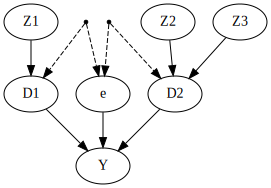

In [35]:
iv = CausalGraphicalModel(
    nodes=["D1", "D2", "Y", "e", "Z1", "Z2", "Z3"],
    edges=[
        ("Z1", "D1"), 
        ("D1", "Y"),
        ("e", "Y"),
        ("Z2", "D2"),
        ("Z3", "D2"),
        ("D2", "Y")
    ],
    latent_edges=[
        ("e", "D1"),
        ("e", "D2")
    ]
)

iv.draw()

In [36]:
units = 10000
alpha = 5
#Homicide rates increase with alienation and decrease with activism
delta1 = 20
delta2 = -10

Z1 = np.random.uniform(0, 100, size=units) #Alienation metric
Z2 = np.random.uniform(0, 50, size=units) #Average amount of television
Z3 = np.random.uniform(0, 100, size=units) #Extreme political attitudes

e = np.random.uniform(0, 10, size=units) #Individual effects

#Social trust decreases with alienation
mu_d1 = (e - Z1) / 2
D1 = np.random.normal(mu_d1)

#Social activism decreases with television and increases with extreme political attitudes
mu_d2 = (e - Z2 + Z3) / 3
D2 = np.random.normal(mu_d2)

Y = alpha + delta1 * D1 + delta2 * D2 + e

df = pd.DataFrame({'Z1': Z1, 'Z2': Z2, 'Z3': Z3, 'e': e, 'D1': D1, 'D2': D2, 'Y': Y})

In [37]:
df[['Z1', 'D1']].corr()

,Z1,D1
Z1,1.000000,-0.992495
D1,-0.992495,1.000000


In [38]:
df[['Z2', 'Z3', 'D2']].corr()

,Z2,Z3,D2
Z2,1.000000,-0.003257,-0.448055
Z3,-0.003257,1.000000,0.886096
D2,-0.448055,0.886096,1.000000


We have strong correlations between each IV and their respective causal states.

In [39]:
df[['Z1', 'Z2', 'Z3', 'e']].corr()

,Z1,Z2,Z3,e
Z1,1.000000,-0.001804,0.000043,-0.004214
Z2,-0.001804,1.000000,-0.003257,0.000290
Z3,0.000043,-0.003257,1.000000,0.006037
e,-0.004214,0.000290,0.006037,1.000000


No strong correlations between IVs and the error term $e$.

Try to recover $\delta_1$ with OLS.

In [40]:
df['intercept'] = 1
instrument_model = OLS(df['D1'], df[['Z1', 'intercept']])
instrument_result = instrument_model.fit()
instrument_result.summary()

df['D1_expected'] = instrument_result.predict(df[['Z1', 'intercept']])
causal_model = OLS(df['Y'], df[['D1_expected', 'intercept']])
result = causal_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                 6.580e+04
Date:                Mon, 17 Dec 2018   Prob (F-statistic):               0.00
Time:                        07:40:50   Log-Likelihood:                -61407.
No. Observations:               10000   AIC:                         1.228e+05
Df Residuals:                    9998   BIC:                         1.228e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
D1_expected    19.9965      0.078    256.512      0.000      19.844      20.149
intercept     -90.4536      2.079    -43.511      0.000     -94.529     -86.379
==============================================================================
Omnibus:                      466.106   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.410
Skew:                           0.025   Prob(JB):                     4.50e-42
Kurtosis:                       2.326   Cond. No.                         49.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We were able to recover $\delta_1$. Error in the intercept indicates that we are not capturing some feature, $D_2$.

In [41]:
instrument_model = OLS(df['D2'], df[['Z2', 'Z3', 'intercept']])
instrument_result = instrument_model.fit()
instrument_result.summary()

df['D2_expected'] = instrument_result.predict(df[['Z2', 'Z3', 'intercept']])
causal_model = OLS(df['Y'], df[['D2_expected', 'intercept']])
result = causal_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     1388.
Date:                Mon, 17 Dec 2018   Prob (F-statistic):          1.35e-284
Time:                        07:40:50   Log-Likelihood:                -70885.
No. Observations:               10000   AIC:                         1.418e+05
Df Residuals:                    9998   BIC:                         1.418e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
D2_expected   -10.0286      0.269    -37.256      0.000     -10.556      -9.501
intercept    -438.4303      3.963   -110.627      0.000    -446.199    -430.662
==============================================================================
Omnibus:                     6625.819   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              568.539
Skew:                          -0.007   Prob(JB):                    3.49e-124
Kurtosis:                       1.832   Cond. No.                         20.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$\delta_2$ is estimable as well, and again there is error in the intercept if we only estimate one causal effect.  
Estimate the entire data generating process at once.

In [42]:
causal_model = OLS(df['Y'], df[['D1_expected', 'D2_expected', 'intercept']])
result = causal_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 4.686e+05
Date:                Mon, 17 Dec 2018   Prob (F-statistic):               0.00
Time:                        07:40:50   Log-Likelihood:                -48779.
No. Observations:               10000   AIC:                         9.756e+04
Df Residuals:                    9997   BIC:                         9.759e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
D1_expected    19.9901      0.022    906.460      0.000      19.947      20.033
D2_expected   -10.0059      0.030   -339.020      0.000     -10.064      -9.948
intercept       9.8349      0.658     14.940      0.000       8.544      11.125
==============================================================================
Omnibus:                       42.504   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.675
Skew:                          -0.006   Prob(JB):                     1.32e-07
Kurtosis:                       2.725   Cond. No.                         58.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now we have good estimates for both $\delta_i$.  
**Note** $\alpha$ is biased by 5, is this because of the error term $e$? If so how do we alleviate this?

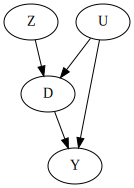

In [43]:
iv_unblocked = CausalGraphicalModel(
    nodes=['Z', 'D', 'U', 'Y'],
    edges=[
        ('Z', 'D'),
        ('D', 'Y'),
        ('U', 'D'),
        ('U', 'Y')
    ]
)

iv_unblocked.draw()

$iv_{unblocked}$ has a valid IV $Z$ and an unblocked backdoor path $D \leftarrow U \rightarrow Y$.  
Now if we test for the validity of $Z$ as an IV by calculating the association of $Z$ and $Y$ while conditioning on $D$ we will find one, since conditioning on $D$ creates an association between $Z$ and $U$ that was previously blocked ($D$ is a collider).

In [44]:
units = 10000
alpha = 5
delta = 10

Z = np.random.normal(0, size=units)

U = np.random.normal(0, size=units)

p_d = 1 / (1 + np.exp(Z + U))
D = np.random.binomial(1, p_d)

Y = alpha + delta * D + U

df = pd.DataFrame({'Z': Z, 'U': U, 'D': D, 'Y': Y})

There is no correlation between $Z$ and $U$ from the data generating process.

In [45]:
df[['Z', 'U']].corr()

,Z,U
Z,1.000000,-0.001917
U,-0.001917,1.000000


Calculate the covariance of $Z$ and $Y$ using the conditional covariance on $D$.

${\displaystyle \operatorname {cov} (Z,Y)=\operatorname {E} (\operatorname {cov} (Z,Y\mid D))+\operatorname {cov} (\operatorname {E} (Z\mid D),\operatorname {E} (Y\mid D)).}$

In [46]:
p_d1 = df[df['D'] == 1].shape[0]

In [47]:
E_cov_given_d = df[df['D'] == 1][['Z', 'Y']].corr().Z.Y * p_d1 + df[df['D'] == 0][['Z', 'Y']].corr().Z.Y * (1 - p_d1)

In [48]:
cond_exp = np.array([[df[df['D'] == 1].Z.mean(), df[df['D'] == 0].Z.mean()], [df[df['D'] == 1].Y.mean(), df[df['D'] == 0].Y.mean()]])

In [49]:
cov_exp_given_d = np.cov(cond_exp, rowvar=True)[0][1]

In [50]:
E_cov_given_d + cov_exp_given_d

76.04676384975099

Despite $Z$ being a valid IV, if we required that there be no association between $Z$ and $Y$ conditional on $D$ we would reject $Z$ as a candidate IV.

Problems with IVs:  
1. Assumption that an IV does not have a direct effect on the outcome variable is hard to defend, and  
2. Even with that assumption, in finite samples IV estimators are biased. This bias can be substantial if the IV weakly predicts the causal variable.

### LATE Estimation

Compliers (C = c) : $D^{Z=0} = 0$ and $D^{Z=1} = 1$,  
Defiers (C = d) : $D^{Z=0 = 1}$ and $D^{Z=1} = 0$,  
Always takers (C = a) : $D^{Z=0} = 1$ and $D^{Z=1} = 1$,  
Never takers (C = n) : $D^{Z=0} = 0$ and $D^{Z=1} = 0$.

In order for valid IV $Z$ for the causal effect of $D$ on $Y$ to identify a LATE:  
1. Independence assumption: $Y^1, Y^0, D^{Z=1}, D^{Z=0}$ are independent of $Z$,  
2. Nonzero effect of instrument assumption: $\kappa \ne 0$ for all $i$, where $\kappa = D^{Z=1} - D^{Z=0}$,  
3. Monotonicity assumption: either $\kappa \ge 0$ for all $i$ or $\kappa \le 0$ for all $i$.

Together the nonzero effect of instrument amd monotonicity assumptions require that our data includes exactly one of compliers or defiers.

With all three assumptions, the IV $Z$ identifies the LATE, the ATE for the subset of the population whose treatment selection is induced by the instrument (either compliers or defiers).

Determine whether private high schools outperform public  
Causal state: $D$ attending private high school  
IV: $Z$ winning school voucher  
Outcome: $Y$ standardized test score

In [70]:
units = 10000
delta = 10

Z = np.random.binomial(1, .2, size=units) #Voucher lottery

#Chance of attending private schools cannot decrease with vouchers
p_d = .1
D_0 = np.random.binomial(1, p_d, size=units)
D_1 = (D_0==1) * 1 + (D_0==0) * np.random.binomial(1, .5, size=units)

D = (Z==1) * D_1 + (Z==0) * D_0

#e = np.random.normal(size=units) #Individual effects
Y_0 = 50
Y_1 = 50 + delta

Y = (D==1) * Y_1 + (D==0) * Y_0

df = pd.DataFrame({'Z': Z, 'D': D, 'Y': Y})

In [71]:
df[['Z', 'D']].corr()

,Z,D
Z,1.000000,0.465903
D,0.465903,1.000000


There are no defiers, as a consequence of the data generating process.

In [72]:
(((D_0 == 1) * 1 + (D_1 == 0) * 1) == 2).sum()

0

Calculate conditional expectations

In [73]:
p_d1 = df[df['D'] == 1].shape[0] / units
p_d1z1 = df[df['D'] == 1][df['Z'] == 1].shape[0] / units
p_d0z1 = df[df['D'] == 0][df['Z'] == 1].shape[0] / units

/home/eric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/eric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [74]:
exp_given_d1 = ((p_d1z1 * df[df['D'] == 1][df['Z'] == 1].Y.mean()) +
                (p_d1 - p_d1z1) * df[df['D'] == 1][df['Z'] == 0].Y.mean()) / p_d1

/home/eric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/eric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [75]:
exp_given_d0 = ((p_d0z1 * df[df['D'] == 0][df['Z'] == 1].Y.mean()) +
                (1 - p_d1 - p_d0z1) * df[df['D'] == 0][df['Z'] == 0].Y.mean()) / (1 - p_d1)

/home/eric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/eric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [76]:
(exp_given_d1, exp_given_d0)

(60.0, 50.00000000000001)

Calculate the WALD estimator

In [77]:
exp_y_given_z1 = (p_d1z1 * df[df['D'] == 1][df['Z'] == 1].Y.mean() + p_d0z1 * df[df['D'] == 0][df['Z'] == 1].Y.mean()) / (p_d1z1 + p_d0z1)

/home/eric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/eric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [78]:
exp_y_given_z0 = ((p_d1 - p_d1z1) * df[df['D'] == 1][df['Z'] == 0].Y.mean() + (1 - p_d1 - p_d0z1) * df[df['D'] == 0][df['Z'] == 0].Y.mean()) / (1 - p_d1z1 - p_d0z1)

/home/eric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/eric/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [79]:
exp_d_given_z1 = df[df['Z'] == 1].D.sum() / df[df['Z'] == 1].shape[0]

In [80]:
exp_d_given_z0 = df[df['Z'] == 0].D.sum() / df[df['Z'] == 0].shape[0]

In [81]:
delta_W = (exp_y_given_z1 - exp_y_given_z0) / (exp_d_given_z1 - exp_d_given_z0)
delta_W

10.000000000000007

We were able to recover $\delta = 10$, since the causal effect is consistent across individuals. If the causal effect were inconsistent, we would recover the average treatment effect.